# LSTM을 이용한 로이터뉴스 카테고리 분류

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
from tensorflow.keras.datasets import reuters
(X_train, y_train), (X_test,y_test) = reuters.load_data(num_words=None, test_split=0.2)

C:\Users\CPB06GameN\miniconda3\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\CPB06GameN\miniconda3\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


### 데이터 탐색

In [8]:
category = np.max(y_train) + 1
print(f'카테고리 갯수 : {category}')
len(X_train), len(X_test)

카테고리 갯수 : 46


(8982, 2246)

In [9]:
# 첫번째 뉴스
print(X_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [10]:
index_dict = {}

for key, value in reuters.get_word_index().items():
    index_dict[value] = key

len(index_dict)

557056/550378 [==============================] - 0s 0us/step


30979

In [11]:
# 첫번째 기사 복원
' '.join(index_dict[s] for s in X_train[0])

'the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs'

In [12]:
# 뉴스 기사의 길이
print('뉴스 최대 길이 : ', max(len(l) for l in X_train))
print('뉴스 평균 길이 : ', sum(map(len,X_train)) / len(X_train))

뉴스 최대 길이 :  2376
뉴스 평균 길이 :  145.5398574927633


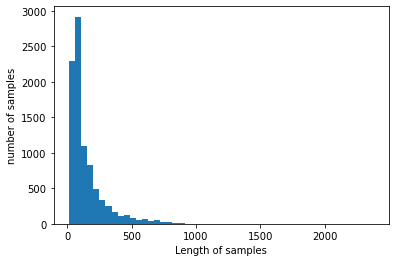

In [13]:
plt.hist([len(l) for l in X_train],bins=50)
plt.xlabel('Length of samples')
plt.ylabel('number of samples')
plt.show()

C:\Users\CPB06GameN\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


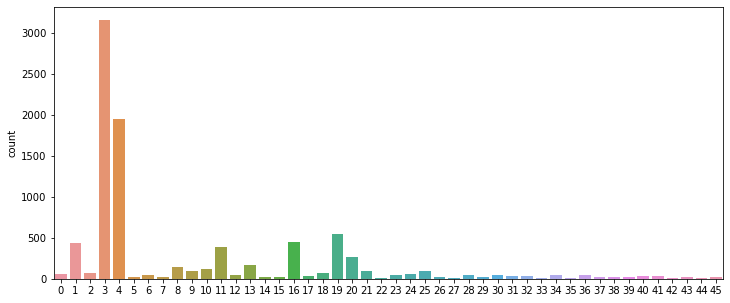

In [15]:
plt.figure(figsize=(12,5))
sns.countplot(y_train)
plt.show()

### 단어 빈도수 기준 1000단어 (총 단어는 30,979)  
### 문장 길이 : 100단어까지 (제일 긴 문장은 2376)

In [16]:
(X_train, y_train), (X_test,y_test) = reuters.load_data(num_words=1000, test_split=0.2)

C:\Users\CPB06GameN\miniconda3\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\CPB06GameN\miniconda3\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


모델의 입력으로 사용되는 모든 뉴스기사의 길이를 동일하게 100으로 맞춤

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 100
X_train = pad_sequences(X_train,maxlen=max_len)
X_test = pad_sequences(X_test,maxlen=max_len)

뉴스 기사 레이블의 원 핫 인코딩

In [18]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [19]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8982, 100), (2246, 100), (8982, 46), (2246, 46))

In [20]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [21]:
model = Sequential([
    Embedding(1000, 100),
    LSTM(120),
    Dense(category,activation='softmax')
])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         100000    
_________________________________________________________________
lstm (LSTM)                  (None, 120)               106080    
_________________________________________________________________
dense (Dense)                (None, 46)                5566      
Total params: 211,646
Trainable params: 211,646
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         100000    
_________________________________________________________________
lstm (LSTM)                  (None, 120)               106080    
_________________________________________________________________
dense (Dense)                (None, 46)                5566      
Total params: 211,646
Trainable params: 211,646
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(
    optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy']
)

In [25]:
# Callback 함수
model_path = 'model/Reuters_bestmodel.h5'
checkpointer = ModelCheckpoint(
    model_path, monitor='val_loss', verbose=1, save_best_only=True
)
early_stopping = EarlyStopping(patience=10)

In [26]:
# 모델 학습
history = model.fit(X_train, Y_train, epochs=50, validation_split=0.2, verbose=2, callbacks=[checkpointer, early_stopping] )

Epoch 1/50

Epoch 00001: val_loss improved from inf to 2.04299, saving model to model\Reuters_bestmodel.h5
225/225 - 14s - loss: 2.3168 - accuracy: 0.4262 - val_loss: 2.0430 - val_accuracy: 0.4953
Epoch 2/50

Epoch 00002: val_loss improved from 2.04299 to 1.78564, saving model to model\Reuters_bestmodel.h5
225/225 - 12s - loss: 1.9302 - accuracy: 0.5081 - val_loss: 1.7856 - val_accuracy: 0.5531
Epoch 3/50

Epoch 00003: val_loss improved from 1.78564 to 1.64569, saving model to model\Reuters_bestmodel.h5
225/225 - 12s - loss: 1.7183 - accuracy: 0.5585 - val_loss: 1.6457 - val_accuracy: 0.5888
Epoch 4/50

Epoch 00004: val_loss did not improve from 1.64569
225/225 - 12s - loss: 1.5872 - accuracy: 0.5926 - val_loss: 1.7460 - val_accuracy: 0.5537
Epoch 5/50

Epoch 00005: val_loss improved from 1.64569 to 1.58114, saving model to model\Reuters_bestmodel.h5
225/225 - 12s - loss: 1.5253 - accuracy: 0.6058 - val_loss: 1.5811 - val_accuracy: 0.6016
Epoch 6/50

Epoch 00006: val_loss improved from

In [27]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

71/71 [==============================] - 1s 17ms/step - loss: 1.2673 - accuracy: 0.6959


[1.267320156097412, 0.6959038376808167]

### 학습 과정 시각화  
- 하나의 X축, 두개의 Y축 스케일

In [31]:
y_acc = history.history['accuracy']
y_vacc = history.history['val_accuracy']
y_loss = history.history['loss']
y_vloss = history.history['val_loss']
x_len= np.arange(1,len(y_acc) + 1)

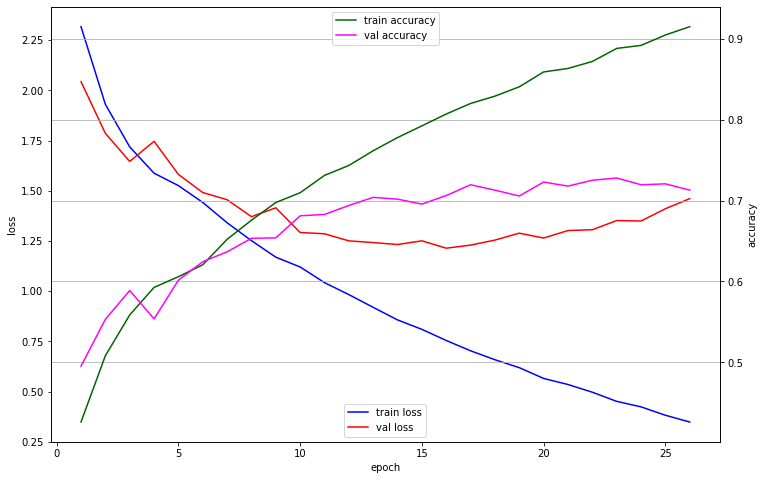

In [35]:
fig, ax0 = plt.subplots(figsize = (12,8))
ax1 = ax0.twinx()           # x축을 공유할 것이다 

ax0.plot(x_len, y_loss, c = 'blue', label ='train loss')
ax0.plot(x_len, y_vloss, c='red', label = 'val loss')
ax0.set_ylabel('loss')

ax1.plot(x_len, y_acc, c = 'darkgreen', label ='train accuracy')
ax1.plot(x_len, y_vacc, c='magenta', label = 'val accuracy')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')

ax0.legend(loc='lower center'); ax1.legend(loc='upper center')
plt.grid()
plt.show()